In [304]:
from mnist import MNIST
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import operator

In [305]:
mndata = MNIST('C:\\Users\\tulsy\\Desktop\\CSE 253\\prog2')

In [306]:
images_train, labels_train = mndata.load_training()
images_test, labels_test = mndata.load_testing()

In [307]:
images_train = np.array(images_train)/127.5 -1
images_test = np.array(images_test)/127.5 -1
images_train = np.hstack((np.ones((60000,1)),images_train))
images_test = np.hstack((np.ones((10000,1)),images_test))

In [308]:
# Divide data into training and testing
Images_train =[]
lable_train =[]
Images_val =[]
Labels_val =[]

Images_train = images_train[:48000]
lable_train = labels_train[:48000]
Images_val = images_train[-12000:]
Labels_val =labels_train[-12000:]
print(np.shape(Images_train))


(48000, 785)


In [309]:
def one_hot_enc(data):
    sz = len (data)
    enc = np.zeros ((sz, 10))
    enc [range(sz), np.array(data)] = 1
    return enc

In [310]:
label_train_oh = one_hot_enc(lable_train)
label_val_oh = one_hot_enc(Labels_val)
label_test_oh = one_hot_enc(labels_test)

In [311]:
def Sigmoid(X, tan):
    if (tan  == 0):
        return 1.0/(1 + np.exp(-X))
    else:
        return 1.7159 * np.tanh((2/3)*X)

In [312]:
def SigmoidP(X, tan):
    if (tan == 0):
        return Sigmoid(X,tan)*(1-Sigmoid(X,tan))
    else:
        return 1.7159*(2/3)* (1- ((np.tanh((2/3)*X))*(np.tanh((2/3)*X))))

In [313]:
def get_softmax_prob (Input_O):
    ex = np.exp (Input_O)
    temp = np.sum(ex, axis=1)
    v = ex/np.resize(temp,(temp.shape[0],1))
    return v 

def get_softmax_pred (sm_prob):
    for i in range(len(sm_prob)):
        l = sm_prob[i]
        index, value = max(enumerate(l), key=operator.itemgetter(1))
        sm_prob[i] =0
        sm_prob[i][index] =1
    return sm_prob





In [314]:
#def Network(Training_Set_size, No_hidden_layer, No_hidden_nodes,lr1,lr2,epochs):
def feedforward(WIH, WHO,Images_train,batch_size, tan):
    N = batch_size
    Input_H = np.dot(Images_train,WIH.T)
    Activation_H = Sigmoid(Input_H, tan)
    Activation_H = np.hstack((np.ones((N,1)),Activation_H))
    Input_O = np.dot(Activation_H,WHO)
    Softmax_Input_O = get_softmax_prob(Input_O)
    return Input_H,Activation_H,Input_O,Softmax_Input_O

def backprop(Images_train, label_train_oh, Input_H, Activation_H, Input_O, Softmax_Input_O, WIH, WHO,l1,l2,batch_size,tan,momentum,M1,M2):
    N = batch_size
    Y_N = Softmax_Input_O
    diff = label_train_oh - Y_N
    gd_O = np.dot(diff.T,Activation_H)
    D_new=0
    U2_new=0
    if momentum == 1:
        D_old = M1
        Update = D_old*(0.9) - (l2 *(gd_O.T))/N
        WHO = WHO - Update
        D_new = Update
    else:
        WHO = WHO +(l2 *(gd_O.T))/N
    #Y_N = Softmax_Input_O
    #diff = label_train_oh - Y_N
    #gd_O = np.dot(diff.T,Activation_H)
    #Update = D_old*(0.9) - (l2 *(gd_O.T))/N
    
    #WHO = WHO - Update
    #D_new = Update
    who_wb = WHO
    dot1 = np.dot(diff,who_wb.T)
    Ac_T = Activation_H.T
    Acativation_h_wb = Ac_T
    a_sigmoid = SigmoidP(Acativation_h_wb, tan)
    dot2 = np.multiply(dot1,a_sigmoid.T)
    dot3= np.dot(dot2.T,Images_train)
    if momentum == 1:
        D_old2 = M2
        UPDATE2 = D_old2*0.9 -(l1*dot3[1:])/N
        WIH = WIH - UPDATE2
        U2_new  = UPDATE2
    else:
        WIH = WIH +(l1*dot3[1:])/N
    return WIH,WHO,D_new,U2_new

def calOutputHidden(WIH, WHO,Images_val,tan):
    Input_H = np.dot(Images_val,WIH.T)
    Activation_H = Sigmoid(Input_H, tan)
    Activation_H = np.hstack((np.ones((len(Images_val),1)),Activation_H))
    Input_O = np.dot(Activation_H,WHO)
    Softmax_Input_O = get_softmax_prob(Input_O)
    Y_N = Softmax_Input_O
    return Y_N
    
def calculate_loss_and_acc (Y_N,Images_val,label_val_oh):
    err =0
    acc =[]
    acc_f =0
    for i in range(len(Images_val)):
        y_n = Y_N[i]
        t_n = label_val_oh[i]
        dot = np.dot(np.log(y_n),t_n)
        err -= dot
        idx1 = np.argmax(y_n)
        idx2 = np.argmax(t_n)
        if idx1 == idx2:
            acc.append(1)
        else:
            acc.append(0)
    acc_f = (1.0*sum(acc))/len(label_val_oh)
    return err/len(label_val_oh),acc_f
    
    

In [315]:
def Main(Images_train,label_train_oh,Images_val,label_val_oh,images_test,label_test_oh,H,l1,l2,epochs,shuffle1,momentum,tan,weight):
    H1 = H+1
    if weight == 1:
        WIH = np.random.normal(0, (1/np.sqrt(785)), (H,785))
        WHO = np.random.normal(0, (1/np.sqrt(785)), (H1,10))
    else:
        WIH = np.random.normal(0,0.00001, (H,785))
        WHO = np.random.normal(0,0.00001, (H1,10))
    batch_size = 128
    batch_no = int(len(Images_train)/128)
    acc_train =[]
    loss_train =[]
    acc_val =[]
    loss_val =[]
    acc_test =[]
    loss_test =[]
    epoch =[]
    M1=0
    M2=0
    for i in range(epochs):
        if shuffle1 == 1:
            print (i)
            Train_img_shuffle = []
            Train_label_shuffle = []
            shuffle = np.random.permutation(len(Images_train))
            #print(shuffle[:100])
            for sample in shuffle:
                Train_img_shuffle.append (Images_train[sample])
                Train_label_shuffle.append (label_train_oh[sample])
            #Images_train = Train_img_shuffle
            #label_train_oh = Train_label_shuffle
            #print(len(Images_train))
            #print(len(label_train_oh))
        for j in range(batch_no):
            start = j*128
            end = start+128
            if shuffle1 == 1:
                Images_T =Train_img_shuffle[start:end]
                Lables_T =Train_label_shuffle[start:end]
            else:
                Images_T =Images_train[start:end]
                Lables_T =label_train_oh[start:end] 
            Input_H,Activation_H,Input_O,Softmax_Input_O = feedforward(WIH,WHO,Images_T,batch_size,tan)
            WIH_n,WHO_n,M1_n,M2_n = backprop(Images_T, Lables_T, Input_H, Activation_H, Input_O, Softmax_Input_O, WIH, WHO,l1,l2,batch_size,tan,momentum,M1,M2)
            WIH = WIH_n
            WHO = WHO_n
            M1 = M1_n
            M2 = M2_n
        Y_N_train = calOutputHidden(WIH, WHO,Images_train,tan)
        err_t, acc_t = calculate_loss_and_acc(Y_N_train,Images_train,label_train_oh)
        acc_train.append(acc_t)
        loss_train.append(err_t)
        Y_N_val = calOutputHidden(WIH, WHO,Images_val,tan)
        err_v, acc_v = calculate_loss_and_acc(Y_N_val,Images_val,label_val_oh)
        
        acc_val.append(acc_v)
        loss_val.append(err_v)
        Y_N_test = calOutputHidden(WIH, WHO,images_test,tan)
        err_t1, acc_t1 = calculate_loss_and_acc(Y_N_test,images_test,label_test_oh)
        acc_test.append(acc_t1)
        loss_test.append(err_t1)
        epoch.append(i)
        print(i)
    plt.plot(epoch,acc_train, color='blue', label ="Training Acc")
    plt.plot(epoch,acc_val, color ='green',label = "Validation Acc")
    plt.plot(epoch,acc_test, color ='orange', label = "Test Acc")
    plt.title("Accuracy v/s Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    plt.plot(epoch,loss_train, color='blue',label ="Training loss")
    plt.plot(epoch,loss_val, color ='green',label ="Validation loss")
    plt.plot(epoch,loss_test, color ='orange',label ="Test loss")
    plt.title("Loss v/s Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print("Training Accuarcy",max(acc_train))
    print("Validation Accuarcy", max(acc_val))
    print("Test Accuracy", max(acc_test))
    print(np.argmax(np.array(acc_val)))



    
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

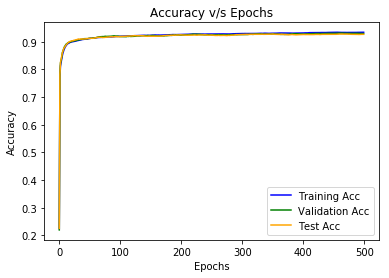

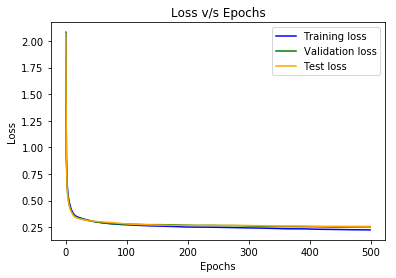

Training Accuarcy 0.9345833333333333
Validation Accuarcy 0.93175
Test Accuracy 0.9285
462


In [316]:
Main(Images_train,label_train_oh,Images_val,label_val_oh,images_test,label_test_oh,64,0.1,0.1,500,0,0,0,0)
#Main(Images_train,label_train_oh,Images_val,label_val_oh,images_test,label_test_oh,64,0.01,0.01,500,0,0,0)

0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
50
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
59
60
60
61
61
62
62
63
63
64
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
90
90
91
91
92
92
93
93
94
94
95
95
96
96
97
97
98
98
99
99
100
100
101
101
102
102
103
103
104
104
105
105
106
106
107
107
108
108
109
109
110
110
111
111
112
112
113
113
114
114
115
115
116
116
117
117
118
118
119
119
120
120
121
121
122
122
123
123
124
124
125
125
126
126
127
127
128
128
129
129
130
130
131
131
132
132
133
133
134
134
135
135
136
136
137
137
138
138
139
139
140
140
141
141
142
142
143
143
144
144
145
145
146
146
147
147
148
148
149
149
150
150
151
151
152


C:\Users\tulsy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


164
165
165
166
166
167
167
168
168
169
169
170
170
171
171
172
172
173
173
174
174
175
175
176
176
177
177
178
178
179
179
180
180
181
181
182
182
183
183
184
184
185
185
186
186
187
187
188
188
189
189
190
190
191
191
192
192
193
193
194
194
195
195
196
196
197
197
198
198
199
199
200
200
201
201
202
202
203
203
204
204
205
205
206
206
207
207
208
208
209
209
210
210
211
211
212
212
213
213
214
214
215
215
216
216
217
217
218
218
219
219
220
220
221
221
222
222
223
223
224
224
225
225
226
226
227
227
228
228
229
229
230
230
231
231
232
232
233
233
234
234
235
235
236
236
237
237
238
238
239
239
240
240
241
241
242
242
243
243
244
244
245
245
246
246
247
247
248
248
249
249
250
250
251
251
252
252
253
253
254
254
255
255
256
256
257
257
258
258
259
259
260
260
261
261
262
262
263
263
264
264
265
265
266
266
267
267
268
268
269
269
270
270
271
271
272
272
273
273
274
274
275
275
276
276
277
277
278
278
279
279
280
280
281
281
282
282
283
283
284
284
285
285
286
286
287
287
288
288
289


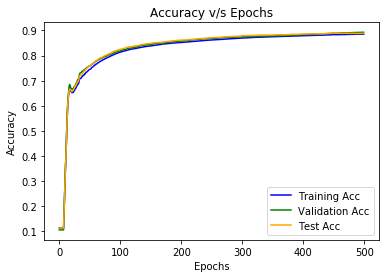

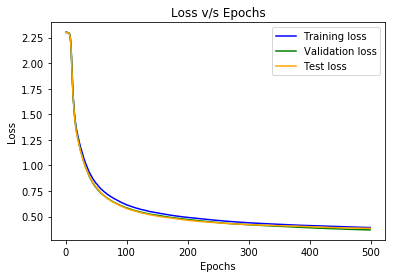

Training Accuarcy 0.8851875
Validation Accuarcy 0.8928333333333334
Test Accuracy 0.89
496


In [320]:
# with shuffle
#Main(Images_train,label_train_oh,Images_val,label_val_oh,images_test,label_test_oh,64,0.1,0.1,500,1,0,0,0)
Main(Images_train,label_train_oh,Images_val,label_val_oh,images_test,label_test_oh,64,0.01,0.01,500,1,0,0,0)

0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
50
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
59
60
60
61
61
62
62
63
63
64
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
90
90
91
91
92
92
93
93
94
94
95
95
96
96
97
97
98
98
99
99
100
100
101
101
102
102
103
103
104
104
105
105
106
106
107
107
108
108
109
109
110
110
111
111
112
112
113
113
114
114
115
115
116
116
117
117
118
118
119
119
120
120
121
121
122
122
123
123
124
124
125
125
126
126
127
127
128
128
129
129
130
130
131
131
132
132
133
133
134
134
135
135
136
136
137
137
138
138
139
139
140
140
141
141
142
142
143
143
144
144
145
145
146
146
147
147
148
148
149
149
150
150
151
151
152


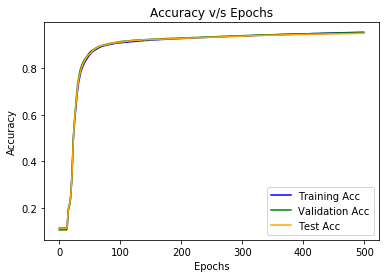

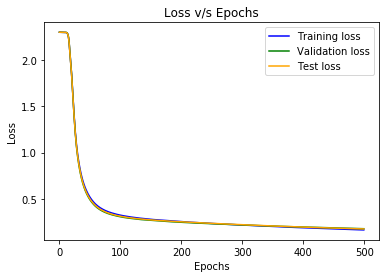

Training Accuarcy 0.953875
Validation Accuarcy 0.95225
Test Accuracy 0.9499
491


In [318]:
# tan
Main(Images_train,label_train_oh,Images_val,label_val_oh,images_test,label_test_oh,64,0.01,0.01,500,1,0,1,0)
#Main(Images_train,label_train_oh,Images_val,label_val_oh,images_test,label_test_oh,64,0.01,0.01,500,1,0,1)

0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
50
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
59
60
60
61
61
62
62
63
63
64
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
90
90
91
91
92
92
93
93
94
94
95
95
96
96
97
97
98
98
99
99
100
100
101
101
102
102
103
103
104
104
105
105
106
106
107
107
108
108
109
109
110
110
111
111
112
112
113
113
114
114
115
115
116
116
117
117
118
118
119
119
120
120
121
121
122
122
123
123
124
124
125
125
126
126
127
127
128
128
129
129
130
130
131
131
132
132
133
133
134
134
135
135
136
136
137
137
138
138
139
139
140
140
141
141
142
142
143
143
144
144
145
145
146
146
147
147
148
148
149
149
150
150
151
151
152


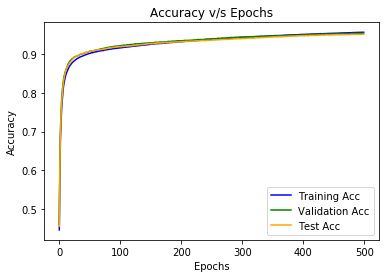

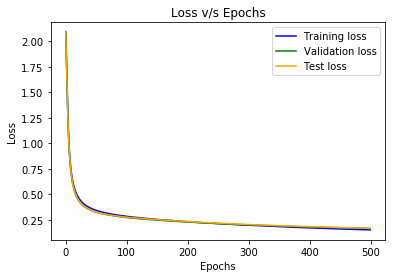

Training Accuarcy 0.9570416666666667
Validation Accuarcy 0.9549166666666666
Test Accuracy 0.9521
498


In [322]:
# weights
Main(Images_train,label_train_oh,Images_val,label_val_oh,images_test,label_test_oh,64,0.001,0.001,500,1,0,1,1)
#Main(Images_train,label_train_oh,Images_val,label_val_oh,images_test,label_test_oh,64,0.01,0.0001,500,1,0,1)

0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
50
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
59
60
60
61
61
62
62
63
63
64
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
90
90
91
91
92
92
93
93
94
94
95
95
96
96
97
97
98
98
99
99
100
100
101
101
102
102
103
103
104
104
105
105
106
106
107
107
108
108
109
109
110
110
111
111
112
112
113
113
114
114
115
115
116
116
117
117
118
118
119
119
120
120
121
121
122
122
123
123
124
124
125
125
126
126
127
127
128
128
129
129
130
130
131
131
132
132
133
133
134
134
135
135
136
136
137
137
138
138
139
139
140
140
141
141
142
142
143
143
144
144
145
145
146
146
147
147
148
148
149
149
150
150
151
151
152


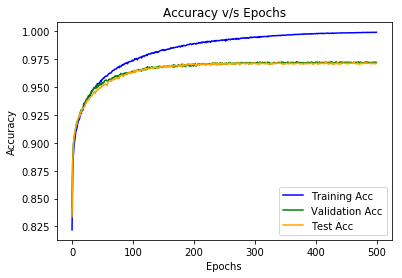

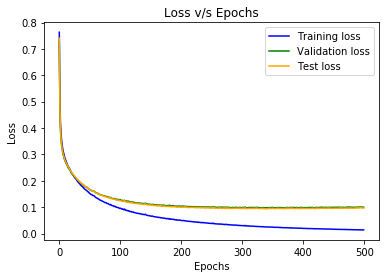

Training Accuarcy 0.999125
Validation Accuarcy 0.9728333333333333
Test Accuracy 0.972
433


In [323]:
# moemtum
Main(Images_train,label_train_oh,Images_val,label_val_oh,images_test,label_test_oh,64,0.001,0.001,500,1,1,1,1)
#Main(Images_train,label_train_oh,Images_val,label_val_oh,images_test,label_test_oh,64,0.01,0.01,500,1,1,1)

0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
50
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
59
60
60
61
61
62
62
63
63
64
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
90
90
91
91
92
92
93
93
94
94
95
95
96
96
97
97
98
98
99
99
100
100
101
101
102
102
103
103
104
104
105
105
106
106
107
107
108
108
109
109
110
110
111
111
112
112
113
113
114
114
115
115
116
116
117
117
118
118
119
119
120
120
121
121
122
122
123
123
124
124
125
125
126
126
127
127
128
128
129
129
130
130
131
131
132
132
133
133
134
134
135
135
136
136
137
137
138
138
139
139
140
140
141
141
142
142
143
143
144
144
145
145
146
146
147
147
148
148
149
149
150
150
151
151
152


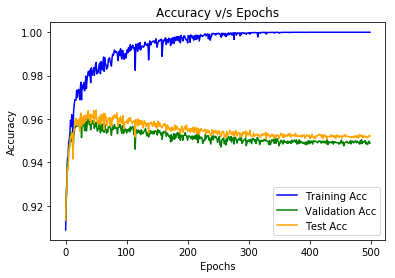

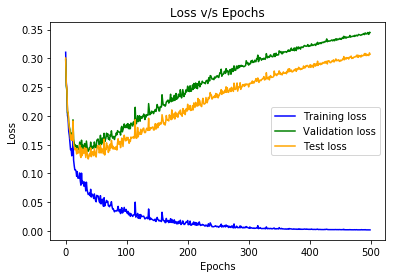

Training Accuarcy 1.0
Validation Accuarcy 0.96
Test Accuracy 0.9641
37
0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
50
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
59
60
60
61
61
62
62
63
63
64
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
90
90
91
91
92
92
93
93
94
94
95
95
96
96
97
97
98
98
99
99
100
100
101
101
102
102
103
103
104
104
105
105
106
106
107
107
108
108
109
109
110
110
111
111
112
112
113
113
114
114
115
115
116
116
117
117
118
118
119
119
120
120
121
121
122
122
123
123
124
124
125
125
126
126
127
127
128
128
129
129
130
130
131
131
132
132
133
133
134
134
135
135
136
136
137
137
138
138
139
139
140
140
141
141
142
142
143
1

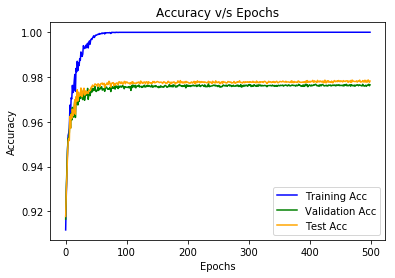

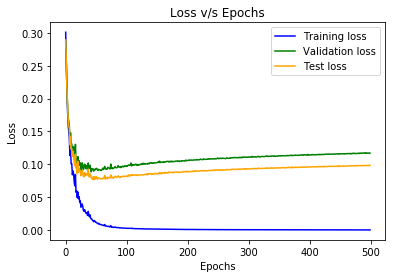

Training Accuarcy 1.0
Validation Accuarcy 0.9769166666666667
Test Accuracy 0.9787
234
0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
50
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
59
60
60
61
61
62
62
63
63
64
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
90
90
91
91
92
92
93
93
94
94
95
95
96
96
97
97
98
98
99
99
100
100
101
101
102
102
103
103
104
104
105
105
106
106
107
107
108
108
109
109
110
110
111
111
112
112
113
113
114
114
115
115
116
116
117
117
118
118
119
119
120
120
121
121
122
122
123
123
124
124
125
125
126
126
127
127
128
128
129
129
130
130
131
131
132
132
133
133
134
134
135
135
136
136
137
137
138
138
139
139
140
140
141
14

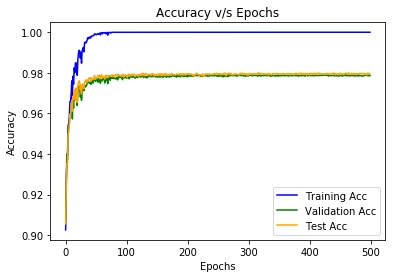

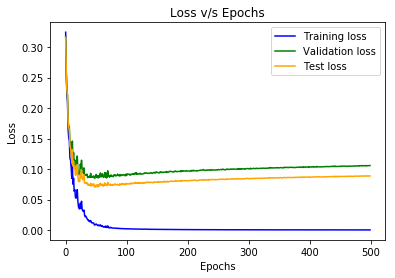

Training Accuarcy 1.0
Validation Accuarcy 0.9791666666666666
Test Accuracy 0.9801
272


In [324]:
# With tan and shuffle data and hidden =32
Main(Images_train,label_train_oh,Images_val,label_val_oh,images_test,label_test_oh,32,0.01,0.01,500,1,1,1,1)
Main(Images_train,label_train_oh,Images_val,label_val_oh,images_test,label_test_oh,128,0.01,0.01,500,1,1,1,1)
Main(Images_train,label_train_oh,Images_val,label_val_oh,images_test,label_test_oh,500,0.01,0.01,500,1,1,1,1)